# Boundary Value Problems

In [3]:
import numpy as np
import matplotlib.pyplot as plt

### Problem Statement

Given condition, $$f''(x) + \sin(x) f'(x) + f(x) = 0$$
$f(x = 0) = 0$ and $f(x = 4 \pi) = 1$

In [4]:
def ODE(func_parameters, x: float, state: np.ndarray) -> np.ndarray:
    # state = [y, vy]
    # func_parameters = [func_p, func_q, func_r]
    p = func_parameters[0](x) * state[1]
    q = func_parameters[1](x) * state[0]
    dvy_dt = func_parameters[2](x) - p - q
    dy_dt = state[1]
    return np.array([dy_dt, dvy_dt])

In [8]:
def rk4_step(func_params, state, x, dx):
    k1 = ODE(func_params, x, state)
    k2 = ODE(func_params, x, state + 0.5 * dx * k1)
    k3 = ODE(func_params, x, state + 0.5 * dx * k2)
    k4 = ODE(func_params, x, state + dx * k3)
    return state + (dx / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)


# Solver
def Solver(func_p, func_q, func_r, state_initial, x_initial, x_max, dx):
    n_steps = int((x_max - x_initial) / dx)
    x_eval = np.linspace(x_initial, x_max, n_steps+1)
    # Function Structure
    func_structure = [func_p, func_q, func_r]

    state = state_initial # [f , f' ]
    y_history = np.zeros(n_steps+1)

    y_history[0] = state[0] # [f]

    for i in range(n_steps):
        state = rk4_step(func_structure, state, x_eval[i], dx)
        y_history[i+1] = state[0]

    return x_eval, y_history

In [9]:
# Using Newton Shooting
def NewtonShooting(func_p, func_q, func_r, x_0: float, x_N: float, y_0: float, y_N: float, N: int, tries: int):
    vy_guess = 1.0
    dx = (x_N - x_0) / N
    plt.figure()
    for i in range(tries):
        state_initial = [y_0, vy_guess]
        x_array, f_array = Solver(func_p, func_q, func_r, state_initial, x_0, x_N, dx)
        plt.plot(x_array, f_array, '-', color = f'#{i*10:06x}', label = f'Guess {i+1}')
        plt.legend()
        plt.grid(True)

        error = f_array[-1] - y_N
        error_eps = Solver(func_p, func_q, func_r, [y_0, vy_guess + 1e-6], x_0, x_N, dx)[1][-1] - y_N
        error_derv = ((error_eps - error) / 1e-6 ) + 1e-9
        vy_guess = vy_guess - (error)/(error_derv)

        if abs(error) < 1e-6:
            print(f'Converged... Error: {error}')
            break
    plt.show()
    return x_array, f_array


Converged... Error: 2.8501061510866066e-09


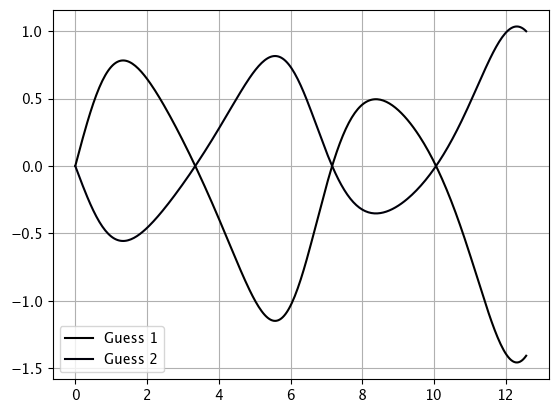

In [10]:
# Equation: y'' + sin(x) y' + y = 0  → p(x)=sin(x), q(x)=1, r(x)=0
func_p = lambda x: np.sin(x)
func_q = lambda x: 1
func_r = lambda x: 0

solution = NewtonShooting(func_p, func_q, func_r, 0, 4*np.pi, 0, 1, 300, 10)

In [21]:
# Using Finite Difference

def finite_diff(func_p, func_q, func_r, x_0: float, x_N: float, y_0: float, y_N: float, N: int) -> np.ndarray:
    h = (x_N - x_0) / N
    x_array = np.linspace(x_0, x_N, N+1)
    A = np.zeros((N-1, N-1))
    RHS = np.zeros(N-1)

    for i in range(1, N):
        x = x_array[i]
        lower = 1/h**2 - func_p(x)/(2*h)
        diag  = -2/h**2 + func_q(x)
        upper = 1/h**2 + func_p(x)/(2*h)

        if i > 1:
            A[i-1, i-2] = lower
        A[i-1, i-1] = diag
        if i < N-1:
            A[i-1, i] = upper

        RHS[i-1] = func_r(x)

    # boundary corrections
    RHS[0]   -= (1/h**2 - func_p(x_array[1])/(2*h)) * y_0
    RHS[-1]  -= (1/h**2 + func_p(x_array[N-1])/(2*h)) * y_N
    # solve system
    Y_inner = np.linalg.solve(A, RHS)
    Y = np.concatenate(([y_0], Y_inner, [y_N]))

    return np.stack((x_array, Y), axis=-1)



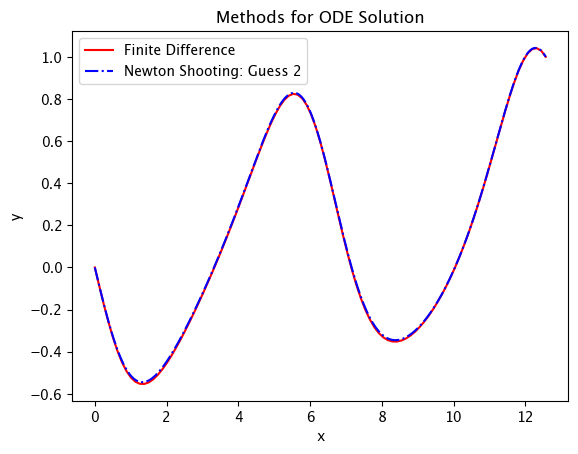

In [22]:
# Equation: y'' + sin(x) y' + y = 0  → p(x)=sin(x), q(x)=1, r(x)=0
func_p = lambda x: np.sin(x)
func_q = lambda x: 1
func_r = lambda x: 0

# Solve
solution_finite = finite_diff(func_p, func_q, func_r, 0, 4*np.pi, 0, 1, N=100)

# Plot
plt.figure()
plt.plot(solution_finite[:,0], solution_finite[:,1], 'r-', markersize = 1, label="Finite Difference")
plt.plot(solution[0], solution[1], 'b-.', markersize = 0.5, label="Newton Shooting: Guess 2")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Methods for ODE Solution")
plt.show()

# PDE


# 2D PDEs – Finite Difference Methods

We now extend the finite-difference method to two dimensions.

## Poisson Equation in 2D

$$
\nabla^2 V = -\frac{\rho}{\epsilon_0}
$$

or equivalently,

$$
\frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} = s(x,y)
$$

where $ s(x,y) = -\rho/\epsilon_0 $.

---

## Discretization

On a grid with step sizes $\Delta x$ and $\Delta y$:

$$
\frac{\partial^2 V}{\partial x^2} \approx \frac{V(x+\Delta x, y) + V(x-\Delta x, y) - 2V(x,y)}{\Delta x^2}
$$

$$
\frac{\partial^2 V}{\partial y^2} \approx \frac{V(x, y+\Delta y) + V(x, y-\Delta y) - 2V(x,y)}{\Delta y^2}
$$

---

## Jacobi Iteration Method

Discretized Poisson equation:

$$
\frac{V_{n+1,m} + V_{n-1,m} - 2V_{n,m}}{\Delta x^2} +
\frac{V_{n,m+1} + V_{n,m-1} - 2V_{n,m}}{\Delta y^2}
= s_{n,m}
$$

Rearranging (for $\Delta x = \Delta y = \Delta$):

$$
V_{n,m}^{(i+1)} =
\frac{V_{n+1,m}^{(i)} + V_{n-1,m}^{(i)} + V_{n,m+1}^{(i)} + V_{n,m-1}^{(i)} - s_{n,m}\Delta^2}{4}
$$

This iteration is repeated until convergence.

---


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [24]:
def Jacobi(V, s, delta, max_iter=5000, tol=1e-6):
    for it in tqdm(range(max_iter), desc= "Iteration: "):
        V_new = V.copy()
        for n in range(1, N+1):
            for m in range(1, M+1):
                V_new[n,m] = 0.25*(V[n+1,m] + V[n-1,m] + V[n,m+1] + V[n,m-1] - s[n,m]*delta*delta)
        if np.linalg.norm(V_new-V)/np.linalg.norm(V_new) < tol:
            print(f"Converged at iteration {it}")
            return V_new
        V = V_new
    return V

In [25]:
def Jacobi_Optimized(V, s, delta, max_iter=5000, tol=1e-6):
    for it in tqdm(range(max_iter), desc= "Iteration: "):
        V_new = V.copy()
        V_new[1:-1,1:-1] = 0.25*(V[2:,1:-1] + V[:-2,1:-1] + V[1:-1,2:] + V[1:-1,:-2] - s[1:-1,1:-1]*delta*delta)
        if np.linalg.norm(V_new-V)/np.linalg.norm(V_new) < tol:
            print(f"Converged at iteration {it}")
            return V_new
        V = V_new
    return V

In [26]:
def GaussSeidel(V, s, delta, max_iter=5000, tol=1e-6):
    for it in tqdm(range(max_iter), desc= "Iteration: "):
        V_prev = V.copy()
        for n in range(1, N+1):
            for m in range(1, M+1):
                V[n,m] = 0.25*(V[n+1,m] + V[n-1,m] + V[n,m+1] + V[n,m-1] - s[n,m]*delta*delta)
        if np.linalg.norm(V - V_prev)/np.linalg.norm(V) < tol:
            print(f"Converged at iteration {it}")
            return V
    return V

### Solving Exercise

In [41]:

N = 100
M = 100
Lx, Ly = 1.0, 1.0
dx = Lx/(N+1)
dy = Ly/(M+1)
V = np.zeros((N+2, M+2))

y = np.linspace(0, Ly, M+2)
V[0, :] = np.sin(2*np.pi*y)

s = (np.zeros((N+2, M+2)))

delta = dx

Iteration: 100%|██████████| 5000/5000 [00:21<00:00, 234.82it/s]


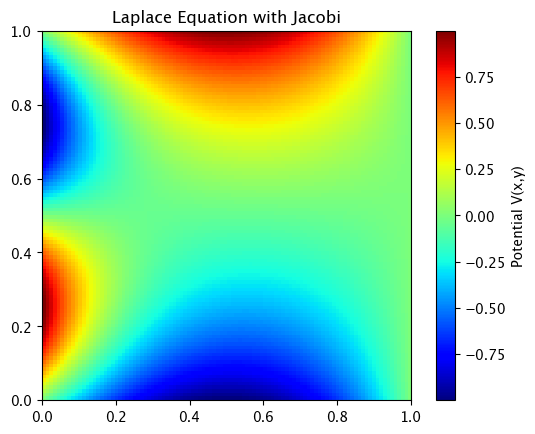

In [28]:

V_sol = Jacobi(V, s, delta)

plt.imshow(V_sol.T, origin='lower', extent=(0,Lx,0,Ly), cmap='jet')
plt.colorbar(label="Potential V(x,y)")
plt.title("Laplace Equation with Jacobi")
plt.show()

Iteration:  24%|██▍       | 4899/20000 [00:00<00:00, 20612.78it/s]

Converged at iteration 4899


Text(0.5, 1.0, 'Laplace Equation with Jacobi Optimized')

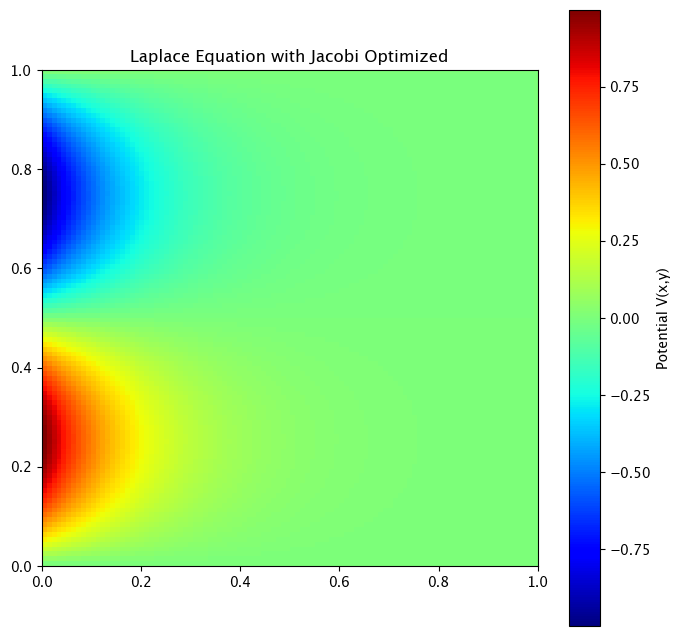

In [42]:
V_Jacobi_opt = Jacobi_Optimized(V, s, delta, max_iter=20000, tol=1e-6)
plt.figure(figsize=(8,8))
plt.imshow(V_Jacobi_opt.T, origin='lower', extent=(0,Lx,0,Ly), cmap='jet')
plt.colorbar(label="Potential V(x,y)")
plt.title("Laplace Equation with Jacobi Optimized")

Iteration:  88%|████████▊ | 4396/5000 [00:19<00:02, 227.07it/s]


Converged at iteration 4396


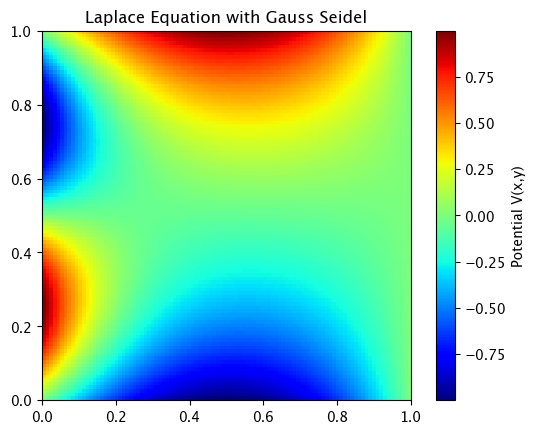

In [30]:

V_sol_Gauss = GaussSeidel(V, s, delta)

plt.imshow(V_sol_Gauss.T, origin='lower', extent=(0,Lx,0,Ly), cmap='jet')
plt.colorbar(label="Potential V(x,y)")
plt.title("Laplace Equation with Gauss Seidel")
plt.show()



### Solving Poisson

In [31]:

N = 100
M = 100
Lx, Ly = 1.0, 1.0
dx = Lx/(N+1)
dy = Ly/(M+1)
V = np.zeros((N+2, M+2))

s = np.ones((N+2, M+2))*(4)

delta = dx


In [32]:
Solu = GaussSeidel(V, s, delta)

Iteration: 100%|██████████| 5000/5000 [00:22<00:00, 223.51it/s]


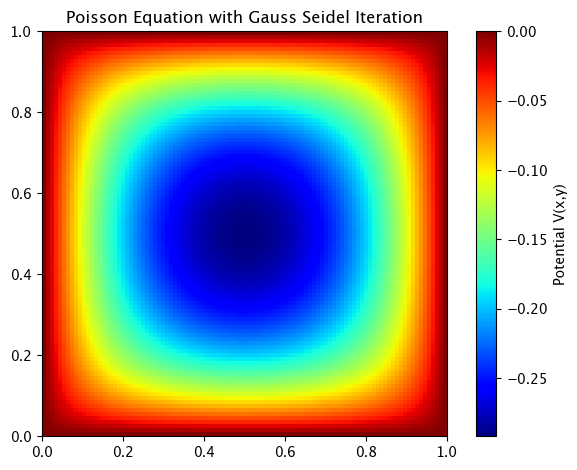

In [33]:
plt.imshow(Solu.T, origin='lower', extent=(0,Lx,0,Ly), cmap='jet')
plt.colorbar(label="Potential V(x,y)")
plt.title("Poisson Equation with Gauss Seidel Iteration")
plt.tight_layout()
plt.show()

---

## Matrix Formulation

Instead of iteration, we can also form a matrix equation.

Define the vector of unknowns:

$$
F =
\begin{bmatrix}
V_{1,1} \\
V_{2,1} \\
\vdots \\
V_{N,M}
\end{bmatrix}
$$

We create matrices $ D_x $ and $ D_y $ representing second derivatives in $x$ and $y$.
The finite difference system becomes:

$$
(D_x + D_y) F + B = S
$$

where $B$ encodes boundary conditions and $S$ the source term.

Finally,

$$
F = (D_x + D_y)^{-1}(S - B)
$$

---

## Applications

- Heat conduction in steady state: $\nabla^2 T = 0$
- Fluid pressure in incompressible hydrodynamics
- Gravitational potential in astrophysics
- General solution of PDEs with finite differences

---


## Matrix Formulation of 2D Poisson Equation

We flatten the $N \times M$ grid of internal points into a column vector:

$$
F =
\begin{bmatrix}
V_{1,1} \\
V_{2,1} \\
\vdots \\
V_{N,M}
\end{bmatrix}
$$

- $D_x$: acts along the x-direction (second derivative wrt $x$)  
- $D_y$: acts along the y-direction (second derivative wrt $y$)  

The discrete Poisson equation becomes:

$$
(D_x + D_y)F + B = S
$$

where $B$ encodes boundary conditions and $S$ is the source term.


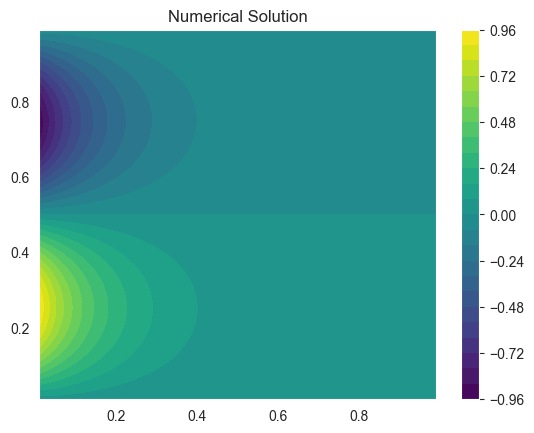

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define N, M and delta
N = 100
M = 100
dx = 1.0 / (N + 1)
dy = 1.0 / (M + 1)


# Create 1D finite difference matrices
def create_1d_laplacian(n):
    main_diag = np.full(n, -2)
    side_diag = np.full(n - 1, 1)
    return np.diag(main_diag) + np.diag(side_diag, 1) + np.diag(side_diag, -1)


# 1D matrices
A_x = create_1d_laplacian(N)
A_y = create_1d_laplacian(M)
I_N = np.eye(N)
I_M = np.eye(M)

# 2D Laplacian using Kronecker products
D_x = np.kron(I_M, A_x)  # ∂²/∂x²
D_y = np.kron(A_y, I_N)  # ∂²/∂y²

L = D_x / (dx ** 2) + D_y / (dy ** 2)

# Boundary condition vectors
V_left = np.sin(2* np.pi * np.linspace(0,1,M))  # V(0,:)
V_right = np.zeros(M)  # V(N+1,:)
V_bottom = np.zeros(N)  # V(:,0)
V_top = np.zeros(N)  # V(:,M+1)

# Pre-scale by dx, dy once
V_left /= dx ** 2
V_right /= dx ** 2
V_bottom /= dy ** 2
V_top /= dy ** 2

# Create source term
x = np.linspace(dx, 1 - dx, N)
y = np.linspace(dy, 1 - dy, M)
X, Y = np.meshgrid(x, y, indexing="ij")

f = 0 * X * Y
f_vec = f.flatten()

# Copy to boundary-corrected RHS
f_bc = f_vec.copy()

for j in range(M):
    for i in range(N):
        k = j * N + i  # Flattened index

        if i == 0:  # Left boundary
            f_bc[k] -= V_left[j]
        if i == N - 1:  # Right boundary
            f_bc[k] -= V_right[j]
        if j == 0:  # Bottom boundary
            f_bc[k] -= V_bottom[i]
        if j == M - 1:  # Top boundary
            f_bc[k] -= V_top[i]

# Solve system
u_vec = np.linalg.solve(L, f_bc)
u_numerical = u_vec.reshape((N, M))

# Plot
plt.contourf(Y, X, u_numerical, levels=25, cmap="viridis")
plt.colorbar()
plt.title("Numerical Solution")
plt.show()


# Time dependent Partial Differential Equations

## Given (your formula)

For the solution $p_n^{N+1}$ at spatial index $n$ and new time $N+1$:

$$
p_n^{N+1} = p_n^{N} - u\frac{\Delta t}{2\Delta x}\,\big(p_{n+1}^{N+1}-p_{n-1}^{N+1}\big).
$$

Define the Courant-like constant
$$
c := \frac{u\,\Delta t}{2\Delta x}.
$$

Rearrange to put all unknowns at time $N+1$ on the left:
$$
p_n^{N+1} + c\,p_{n+1}^{N+1} - c\,p_{n-1}^{N+1} \;=\; p_n^{N}.
$$

So for **interior** nodes the linear equation (for unknown vector $\mathbf p^{N+1}$) has the 3-point stencil
$$
\big[\; -c\;,\; 1 \;,\; +c\;\big]
$$
applied to $(p_{n-1}^{N+1},\,p_n^{N+1},\,p_{n+1}^{N+1})$.
In matrix form (interior rows) that means lower-diagonal = $-c$, diagonal = $1$, upper-diagonal = $+c$.

---

## Neumann boundary $p_x(0,t)=0$ — ghost point substitution

Use the central difference for the derivative at the boundary (time level $N+1$):
$$
p_x(0,t)\approx\frac{p_1^{N+1}-p_{-1}^{N+1}}{2\Delta x}=0
\quad\Longrightarrow\quad p_{-1}^{N+1} = p_1^{N+1}.
$$

Now apply your scheme at the left-most grid point $n=0$:
$$
p_0^{N+1} = p_0^{N} - c\big(p_{1}^{N+1}-p_{-1}^{N+1}\big)
= p_0^{N} - c\big(p_1^{N+1}-p_1^{N+1}\big)
= p_0^{N}.
$$

So the *entire advection contribution cancels at the Neumann boundary*. The left boundary equation becomes
$$
p_0^{N+1} = p_0^{N},
$$
i.e. the first row of the linear system is simply
$$
[\,1,\;0,\;0,\;\dots\,].
$$

The same happens at the right boundary (with $p_{N+1}^{N+1}=p_{N-1}^{N+1}$), so the last row is also an identity row:
$$
[\,\dots,0,\;0,\;1\,].
$$

---

## Small assembled matrix example (5 grid points: indices 0..4)

For advection-only (using $c$ defined above):

$$
S_{\text{adv}} =
\begin{bmatrix}
1 & 0 & 0 & 0 & 0\\
-c & 1 & c & 0 & 0\\
0 & -c & 1 & c & 0\\
0 & 0 & -c & 1 & c\\
0 & 0 & 0 & 0 & 1
\end{bmatrix},
\qquad
S_{\text{adv}}\mathbf p^{N+1} = \mathbf p^{N}.
$$

Note: the boundary rows are identity rows because of the zero-Neumann ghost-point substitution.

---

## If you also have diffusion (advection–diffusion)

If the PDE also has $\alpha p_{xx}$ and you discretize the diffusion implicitly (standard 3-point second difference), let
$$
\mu := \frac{\alpha\,\Delta t}{\Delta x^2}.
$$
The diffusion contributes the usual tridiagonal part $(- \mu)\cdot[1,-2,1]$ (or equivalently you can write $I-\mu L$ with $L$ the unscaled Laplacian). The advection part contributes the skew diagonals $[-c,\,1,\,c]$ as above.

Combine both contributions: the system matrix is
$$
S = I - \mu L + A_{\text{adv}},
$$
where $A_{\text{adv}}$ has $-c$ on the lower diagonal and $+c$ on the upper diagonal. For the **first row** the advection part is zero (cancels), so only the diffusion piece survives — which is why for diffusion-only you see a boundary row proportional to $[-2, 2]$ (or `[-1,1]` if you factor out constants).

Concretely, with both terms present the first row becomes:
$$
[\,1+2\mu,\; -2\mu,\; 0,\; 0,\dots\,],
$$
exactly as in the diffusion-only derivation earlier.

---

## Quick summary / intuition

- The `[-1,1]` / `[-2,2]` pattern you saw earlier comes from **discretizing the second derivative** with a Neumann BC (ghost substitution gives $u_{-1}=u_1$ and the Laplacian at the boundary becomes $2(u_1-u_0)/h^2$).
- Your equation is for the **first derivative (advection)** discretized implicitly and centrally. For that term **with a zero-Neumann boundary** the ghost substitution makes the centered first-difference at the boundary vanish, so the advection part produces an *identity* row (`[1,0,0,...]`) at the boundary.
- If your PDE has *both* advection and diffusion, the boundary row will contain the diffusion contribution while the advection part still cancels (for homogeneous zero-Neumann).

---

If you want, I can:
- show the same derivation for a *nonzero* Neumann $p_x(0,t)=g(t)$ (ghost becomes $p_{-1}=p_1-2h g$), or
- produce a short NumPy snippet that assembles $S$ for the advection-only and advection–diffusion cases and solves one implicit step.

Which would be more useful right now?


$$ p_n^{N+1} = p_n^{N} - u\frac{\delta t}{2\delta x} ( p_{n+1}^{N+1} - p_{n-1}^{N+1} )$$

In [35]:
import numpy as np
A = np.array([[1,2],[3,4]])
B = np.array([[0,5],[6,7]])
np.kron(A,B)
np.kron(B,A)

array([[ 0,  0,  5, 10],
       [ 0,  0, 15, 20],
       [ 6, 12,  7, 14],
       [18, 24, 21, 28]])

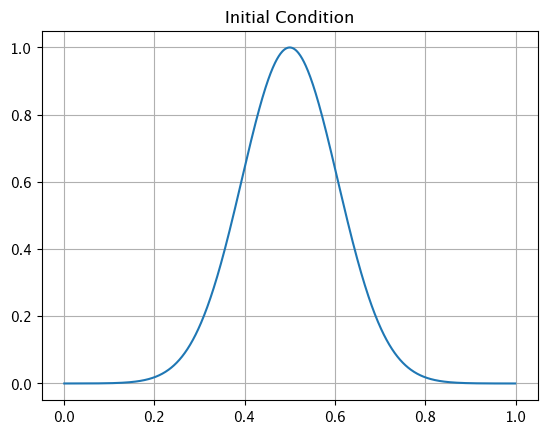

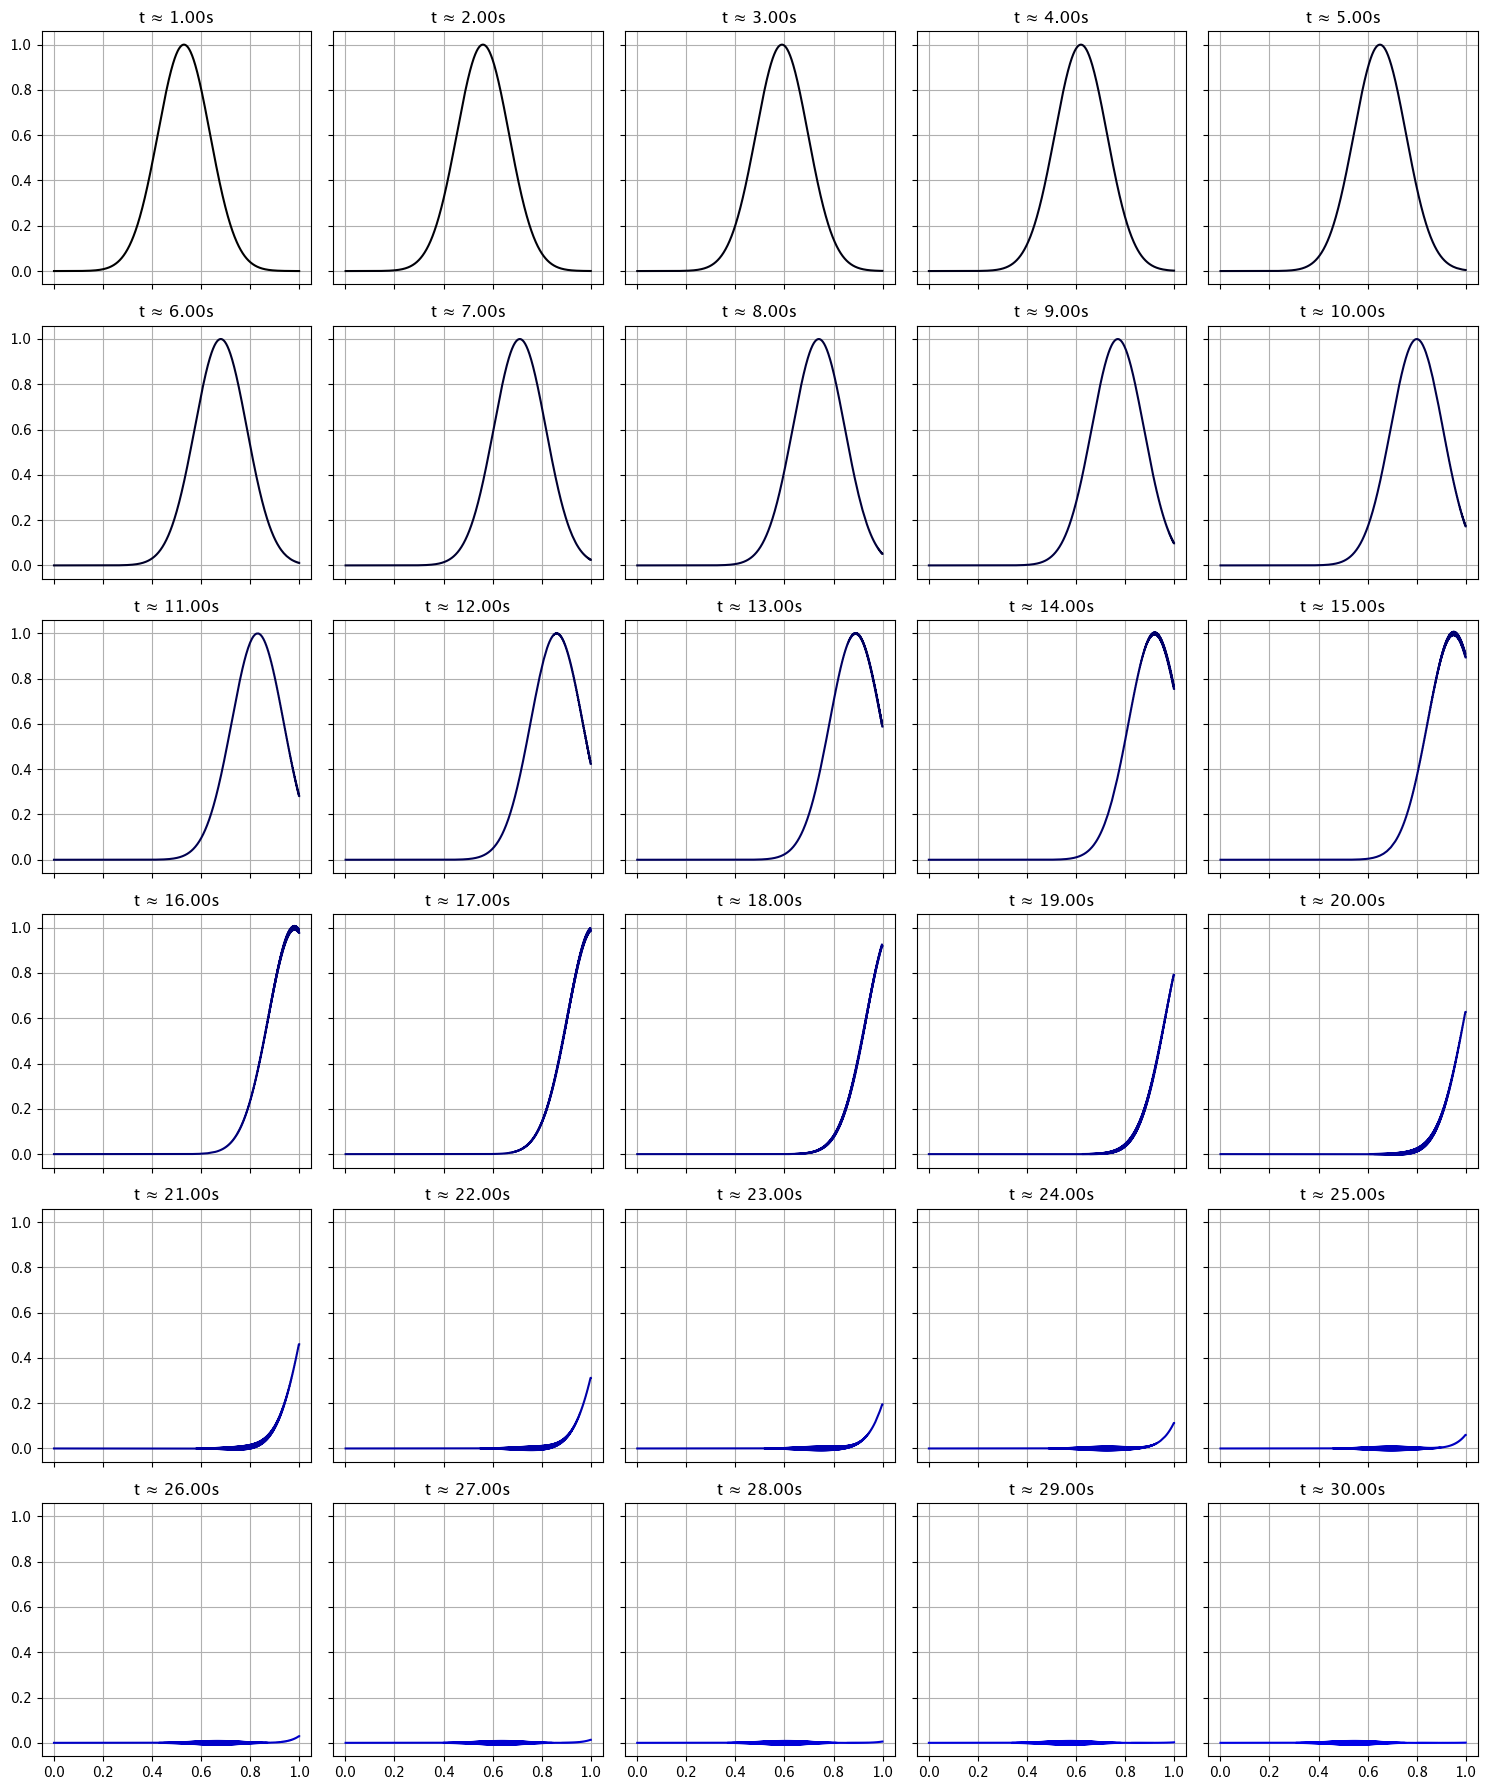

In [60]:
import numpy as np
import matplotlib.pyplot as plt

u = 0.03
dt = 0.001
N = 1000
a, b = 0, 1
x_full = np.linspace(a, b, N+2, dtype=np.float64)
x = x_full[1:-1]
dx = x[1]-x[0]
boundary = "Neumann"

P = np.diag(np.ones(N-1)*(-u*dt/(2*dx)), -1) + np.diag(np.ones(N), 0) + np.diag(np.ones(N-1)*(u*dt/(2*dx)), 1)
if boundary=="Periodic":
    P[0, N-1] = -u*dt/(2*dx)
    P[N-1, 0] =  u*dt/(2*dx)

T = np.linalg.inv(P)

rho0 = np.exp(-((x-0.5)/0.15)**2)
rho = rho0.copy()
# enforce Neumann
rho[0]   = rho[1]
rho[-1]  = rho[-2]

plt.plot(x, rho)
plt.title("Initial Condition")
plt.grid(True)
plt.show()

fig, axes = plt.subplots(6, 5, sharex=True, sharey=True, figsize=(15,18))

snapshots = 30
steps_per_snapshot = int(30.0 / snapshots / dt)  # 10s total
for s in range(snapshots):
    for _ in range(steps_per_snapshot):
        rho = T @ rho
        if boundary == "Neumann":
            # enforce Neumann
            rho[0]   = rho[1]
            rho[-1]  = rho[-2]

    r = s // 5
    c = s % 5
    ax = axes[r, c]
    ax.plot(x, rho, color = f'#{8*s:06X}')
    ax.set_title(f"t ≈ {((s+1)*steps_per_snapshot)*dt:.2f}s")
    ax.grid(True)

plt.tight_layout()
plt.show()


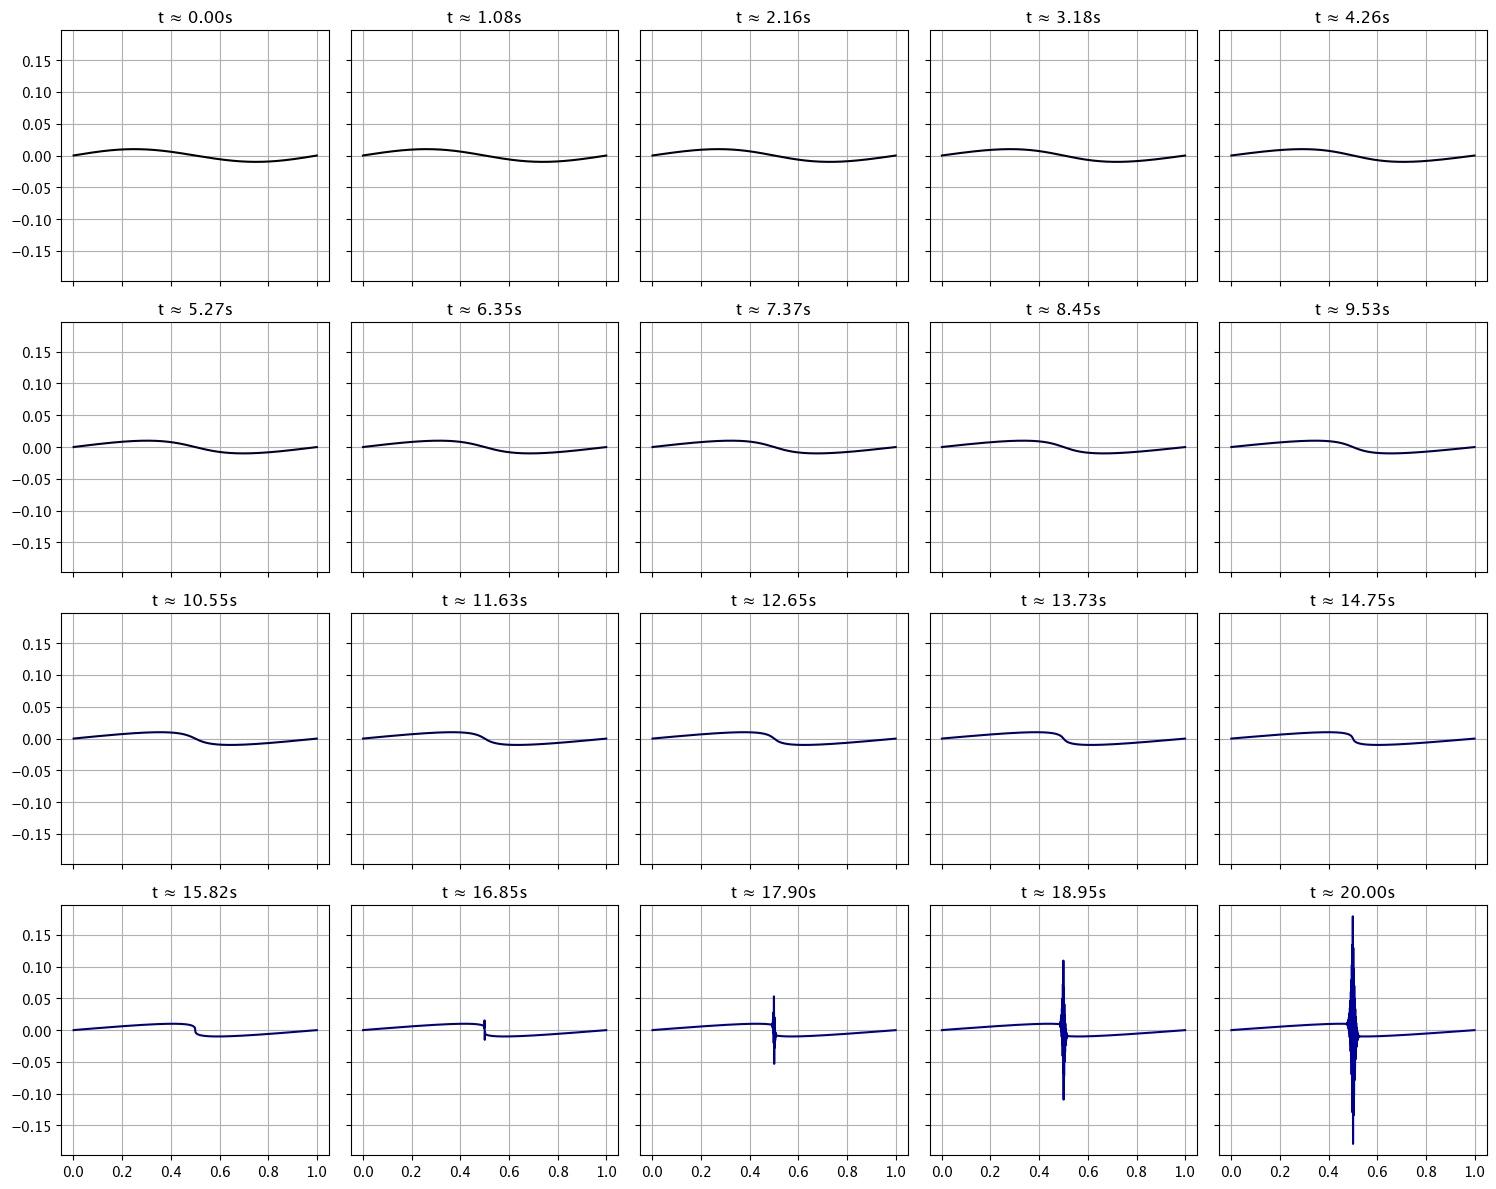

In [80]:
import numpy as np
import matplotlib.pyplot as plt

N = 1000
a, b = 0, 1
x_full = np.linspace(a, b, N+2, dtype=np.float64)
x = x_full[1:-1]
dx = x[1] - x[0]


u = 0.01 * np.sin(2*np.pi*x)
t_max = 20.0
time = 0.0

fig, axes = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(15,12))

snapshots = 20
snapshot_times = np.linspace(0, t_max, snapshots)

s = 0
for snap_t in snapshot_times:
    while time < snap_t:
        u_max = np.max(np.abs(u)) + 1e-9
        dt = 0.6 * dx / u_max
        dt_dx = dt / dx

        # p
        f = 0.5 * u**2
        u_half = 0.5*(u[1:] + u[:-1]) - 0.5*dt_dx*(f[1:] - f[:-1])

        f_half = 0.5 * u_half**2

        u[1:-1] = u[1:-1] - dt_dx * (f_half[1:] - f_half[:-1])

        # periodic wrap for ghost cells
        u[0]  = u[-2]
        u[-1] = u[1]

        time += dt

    r = s // 5
    c = s % 5
    ax = axes[r, c]
    ax.plot(x, u, color=f'#{8*s:06X}')
    ax.set_title(f"t ≈ {time:.2f}s")
    ax.grid(True)
    s += 1

plt.tight_layout()
plt.show()
